In [1]:
### Implementation of Random Forest Bagging classifier with hyper-parameter tuning.
### Data : All 7 folders.

In [39]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn import svm, tree
import xgboost
import os
import csv
from sklearn.model_selection import train_test_split
import seaborn as sns
#------------------
from scipy import fft, arange, signal

In [3]:
folder_root = "../../data/"

In [4]:
def find_files(PATH):
    """
    Finds all the files in a particular directory. Return only .csv files.
    """
    files = []
    for r, d, f in os.walk(PATH):
        for file in f:
            if '.csv' in file:
                files.append(os.path.join(r, file).replace("\\","/"))
    return files

In [5]:
def list_dir_files(root):
    """
    Finds all the files in a nested directory of folders and files (.csv)
    """
    files = []
    friendly_name = []
    for x in os.listdir(root):
        subfolder = root + x
        if os.path.isdir(subfolder):
            onfo = find_files(subfolder)
            if(len(onfo) > 0 and len(x.split("_")) > 1):##Removes test folder and empty folders
                files.append(onfo)
                fn = x.split("/")[-1]
                friendly_name.append(fn)
    return files, friendly_name

In [6]:
files, friendly_name = list_dir_files(folder_root)

In [7]:
def remove_meta_data(PATH):
    """
    Return:
    1. Changes in Electric potential based on Unix timestamp from
        the 5 channels of the Emotiv headset. 2 channels from the Frontal Lobe, 
        1 channel from the parietal lobe, and 2 from temporal lobe.
    2. Pandas Dataframe of the data reflected from (1).
    """
    reader = csv.reader(open(PATH, "rt"), delimiter='\t')
    i = 0
    one_file_data = []
    for line in reader:
        if(i > 0):
            one_file_data.append(line)
        i += 1
    one_file_data = np.array(one_file_data)
    columns = one_file_data[0][0].split(",")[3:8]
    row_data = []
    for rows in one_file_data[1:]:
        rd = rows[0].split(",")[3:8]
        rdt = []
        for x in rd:
            rdt.append(float(x))
        row_data.append(rdt)
    dataframe = pd.DataFrame(row_data, columns=columns)
    return np.array(row_data), dataframe

In [8]:
def data_DF_dir(list_PATH):
    """
    Returns all the data from a given set of path files and its associated pandas dataframe object.
    """
    raw_data = []
    dataframes = []
    for file in list_PATH:
        rd, dfob = remove_meta_data(file)
        raw_data.append(rd)
        dataframes.append(dfob)
    return np.array(raw_data), dataframes

In [9]:
def root_subfolder_file_data(root_list):
    """
    Extracts dataframe and np.array() of each file within each subfolder of the root folder.
    Returns:
    1. n(n will increase)x5(m varies) dataframe
    2. n(n will increase)x5(m varies) np.array()
    """
    root_df = []
    root_np = []
    for x in root_list:
        rnd, rdf = data_DF_dir(x)
        root_df.append(rdf)
        root_np.append(rnd)
    return np.array(root_np), root_df

In [10]:
_, raw_df = root_subfolder_file_data(files)

In [11]:
raw_df[0][0].head() ## Anger 0th file

,EEG.AF3,EEG.T7,EEG.Pz,EEG.T8,EEG.AF4
0,4216.410156,4259.487305,4187.179688,4088.205078,4203.589844
1,4217.948730,4253.846191,4182.051270,4098.974121,4209.230957
2,4211.794922,4252.307617,4165.128418,4102.051270,4214.871582
3,4216.410156,4252.820313,4158.974121,4105.128418,4223.077148
4,4231.794922,4253.333496,4165.641113,4108.717773,4227.692383


In [12]:
def merge_all_data(dataframe, friendly_name, merge_name):
    """
    Merges all dataframes into one dataframe with associated emotion tag.
    """
    list_df_append_emotion = []
    for x,fn in zip(dataframe, friendly_name):
        for fil in x:
            holder = np.full((1, fil.shape[0]), float(fn.split("_")[0])).T
            temp_df = fil
            temp_df[merge_name] = holder
            list_df_append_emotion.append(temp_df)
    pd_df = list_df_append_emotion[0]
    for i in range(1, len(list_df_append_emotion)):
        pd_df = pd_df.append(list_df_append_emotion[i])
    pd_df = pd_df.reset_index().drop(['index'],axis=1)
    return pd_df

In [13]:
df = merge_all_data(raw_df, friendly_name, "emotion")

In [14]:
df.describe()

,EEG.AF3,EEG.T7,EEG.Pz,EEG.T8,EEG.AF4,emotion
count,119540.000000,119540.000000,119540.000000,119540.000000,119540.000000,119540.000000
mean,4215.462872,4297.601779,4143.542524,4134.975258,4196.622698,3.582550
std,223.809288,143.455710,137.496719,141.010738,166.320705,2.900798
min,1529.743530,2809.743652,2167.179443,2592.307617,1709.230713,0.000000
25%,4175.897461,4241.025879,4090.769287,4106.153809,4160.512695,1.000000
50%,4221.538574,4300.000000,4145.128418,4138.461426,4197.948730,3.000000
75%,4264.102539,4359.487305,4197.948730,4169.743652,4236.410156,6.000000
max,8006.666504,5584.615234,6380.000000,6132.820313,6887.692383,8.000000


In [15]:
### Looks good. Data all merged. @ 11:47 am

In [16]:
X = np.array(df.iloc[:,:-1])
y = np.array(df.iloc[:,-1])

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True)

In [18]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape ### Data split.

((95632, 5), (95632,), (23908, 5), (23908,))

In [19]:
classifiers = []
model1 = xgboost.XGBClassifier()
classifiers.append(model1)
# model2 = svm.SVC()
# classifiers.append(model2)
model3 = tree.DecisionTreeClassifier()
classifiers.append(model3)
model4 = RandomForestClassifier()
classifiers.append(model4)
model5 = AdaBoostClassifier()
classifiers.append(model5)
model6 = GradientBoostingClassifier()
classifiers.append(model6)

In [20]:
for clf in classifiers:
    clf.fit(X_train, y_train)
    y_pred= clf.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    print("Accuracy of %s is %s\n"%(type(clf), acc))
    cm = confusion_matrix(y_test, y_pred)
    print("Confusion Matrix of %s is \n%s\n"%(type(clf), cm))

Accuracy of <class 'xgboost.sklearn.XGBClassifier'> is 0.569140036807763

Confusion Matrix of <class 'xgboost.sklearn.XGBClassifier'> is 
[[1392 1047  102  522   63  294  632]
 [ 111 3044    8  119   27  339  363]
 [ 233  446  476  596   25   90  408]
 [ 262  651  111 2537   15  157  510]
 [ 185   94   13  110  191   33   94]
 [  41   82    0   36    0 3624   77]
 [ 222 1331   32  381   16  423 2343]]

Accuracy of <class 'sklearn.tree.tree.DecisionTreeClassifier'> is 0.6006775974569182

Confusion Matrix of <class 'sklearn.tree.tree.DecisionTreeClassifier'> is 
[[2321  422  232  347  130  129  471]
 [ 474 2018  214  336   60  195  714]
 [ 241  202 1207  278   52   49  245]
 [ 385  334  278 2691   64   80  411]
 [ 158   59   43   61  310   19   70]
 [ 137  217   34   62   28 3148  234]
 [ 446  685  266  391   74  220 2666]]



C:\Users\qasim\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Accuracy of <class 'sklearn.ensemble.forest.RandomForestClassifier'> is 0.6865484356700686

Confusion Matrix of <class 'sklearn.ensemble.forest.RandomForestClassifier'> is 
[[2671  478  141  238   68  125  331]
 [ 385 2715   52  150   14  231  464]
 [ 248  232 1317  199   27   45  206]
 [ 325  400  172 2992   17   71  266]
 [ 159   62   25   60  343   15   56]
 [  95  101   12   24    4 3543   81]
 [ 402  839  142  257   25  250 2833]]

Accuracy of <class 'sklearn.ensemble.weight_boosting.AdaBoostClassifier'> is 0.4777480341308349

Confusion Matrix of <class 'sklearn.ensemble.weight_boosting.AdaBoostClassifier'> is 
[[ 756 1082   58  705  354  483  614]
 [  91 2865   11  176   26  372  470]
 [ 203  477  113  850  100  182  349]
 [ 313  787   94 2054  115  343  537]
 [  94  165   13   89  220   49   90]
 [  18  132    0   32    0 3579   99]
 [ 269 1417   34  567   82  544 1835]]

Accuracy of <class 'sklearn.ensemble.gradient_boosting.GradientBoostingClassifier'> is 0.5913083486699013

C

In [21]:
### From the results, the highest accuracy score was that of Random Forest Classifier ~67.25%
results = model4.predict(X[20000:30000])

In [22]:
results = list(results)
print("Class 0 result : " + str(results.count(0)), "\nClass 1 result : " + str(results.count(1)))

Class 0 result : 315 
Class 1 result : 9214


In [36]:
### Hyper-parameter tuning

In [37]:
params={
 "learning_rate"    : [0.05, 0.10, 0.15, 0.20, 0.25, 0.30 ] ,
 "max_depth"        : [ 3, 4, 5, 6, 8, 10, 12, 15],
 "min_child_weight" : [ 1, 3, 5, 7 ],
 "gamma"            : [ 0.0, 0.1, 0.2 , 0.3, 0.4 ],
 "colsample_bytree" : [ 0.3, 0.4, 0.5 , 0.7 ]   
}

In [40]:
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
classifier=xgboost.XGBClassifier()
random_search=RandomizedSearchCV(classifier,param_distributions=params,n_iter=5,n_jobs=-1,cv=5,verbose=3)
random_search.fit(X_train,y_train)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  19 out of  25 | elapsed: 18.8min remaining:  5.9min
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed: 20.0min finished


RandomizedSearchCV(cv=5, error_score='raise-deprecating',
          estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=3, min_child_weight=1, missing=None,
       n_estimators=100, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=None,
       subsample=1, verbosity=1),
          fit_params=None, iid='warn', n_iter=5, n_jobs=-1,
          param_distributions={'learning_rate': [0.05, 0.1, 0.15, 0.2, 0.25, 0.3], 'max_depth': [3, 4, 5, 6, 8, 10, 12, 15], 'min_child_weight': [1, 3, 5, 7], 'gamma': [0.0, 0.1, 0.2, 0.3, 0.4], 'colsample_bytree': [0.3, 0.4, 0.5, 0.7]},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score='warn', scoring=None, verbose=3)

In [43]:
random_search.best_estimator_

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=0.7, gamma=0.3,
       learning_rate=0.1, max_delta_step=0, max_depth=12,
       min_child_weight=7, missing=None, n_estimators=100, n_jobs=1,
       nthread=None, objective='multi:softprob', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=None, subsample=1, verbosity=1)

In [46]:
random_search.best_params_

{'min_child_weight': 7,
 'max_depth': 12,
 'learning_rate': 0.1,
 'gamma': 0.3,
 'colsample_bytree': 0.7}

In [56]:
best_XGB = xgboost.XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=0.7, gamma=0.3,
       learning_rate=0.1, max_delta_step=0, max_depth=12,
       min_child_weight=7, missing=None, n_estimators=100, n_jobs=1,
       nthread=None, objective='multi:softprob', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=None, subsample=1, verbosity=1)

In [61]:
best_XGB.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=0.7, gamma=0.3,
       learning_rate=0.1, max_delta_step=0, max_depth=12,
       min_child_weight=7, missing=None, n_estimators=100, n_jobs=1,
       nthread=None, objective='multi:softprob', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=None, subsample=1, verbosity=1)

In [62]:
y_pred = best_XGB.predict(X_test)

In [63]:
print(accuracy_score(y_test, y_pred))

0.6719089844403547


In [ ]:
### Wow.. After hyper-parameter tuning, xgboost accuracy increased from 56.9% to 67.2%!!!

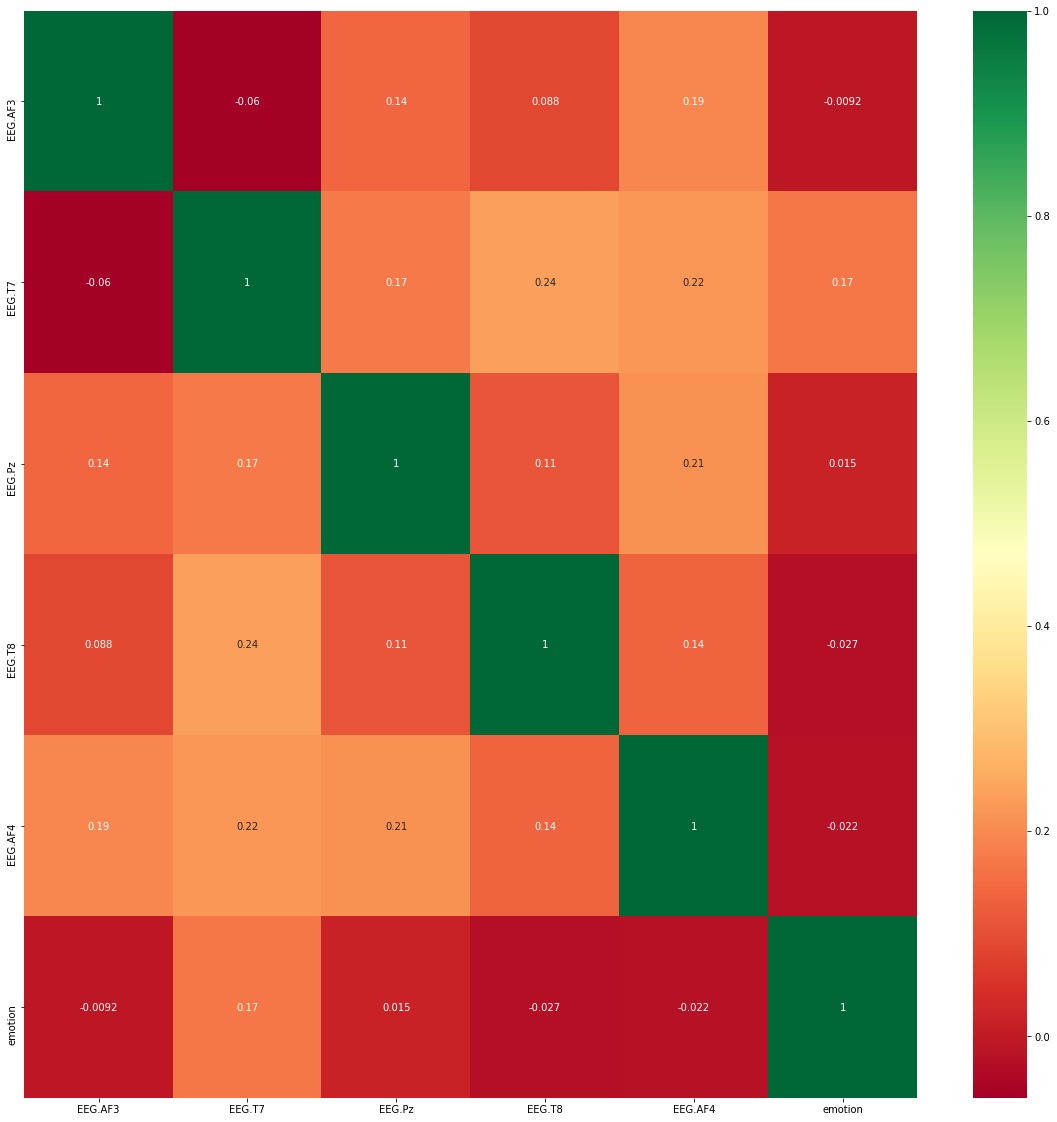

In [24]:
## Correlation
#get correlations of each features in dataset
corrmat = df.corr()
top_corr_features = corrmat.index
plt.figure(figsize=(20,20))
#plot heat map
g=sns.heatmap(df[top_corr_features].corr(),annot=True,cmap="RdYlGn")

In [25]:
### Now, time to validate with real world test data.

In [26]:
test_folder = find_files(folder_root + "Test")

In [27]:
test_data, test_df = data_DF_dir(test_folder)

In [28]:
## data structure : 0,1 -> Anger ; 2,3 -> Happy

In [29]:
def run_test(results, friendly_name):
    for x in friendly_name:
        fn = x.split("_")
        print(fn[1] + " Count : " + str(test_results.count(int(fn[0]))))

In [30]:
test_results = list(model3.predict(test_data[1][512:-100]))
run_test(test_results, friendly_name)

Anger Count : 1304
Fear Count : 2147
Disgust Count : 347
Happiness Count : 822
Sadness Count : 443
Neutral Count : 270
Love Count : 1367


In [31]:
#Fear works...
# Reflection... need same video.

In [32]:
test_folder

['../../data/Test/d0_28.12.19_16.01.33.bp.csv',
 '../../data/Test/fear0_28.12.19_13.44.00.bp.csv',
 '../../data/Test/h0_28.12.19_15.22.43.bp.csv',
 '../../data/Test/lo_28.12.19_15.15.18.bp.csv',
 '../../data/Test/lv_test1_28.12.19_15.26.03.bp.csv',
 '../../data/Test/n0_28.12.19_13.38.29.bp.csv',
 '../../data/Test/n1_28.12.19_13.39.14.bp.csv',
 '../../data/Test/sad0_28.12.19_15.18.44.bp.csv']

In [33]:
test_data[0][0:-1]

array([[4308.205078, 4353.846191, 4171.794922, 4099.487305, 4271.794922],
       [4289.743652, 4360.512695, 4171.282227, 4083.076904, 4267.692383],
       [4282.05127 , 4322.05127 , 4144.102539, 4076.923096, 4252.307617],
       ...,
       [4957.94873 , 4405.641113, 4214.871582, 4274.871582, 5130.769043],
       [4948.205078, 4408.205078, 4218.461426, 4270.769043, 5128.205078],
       [4939.487305, 4409.230957, 4202.563965, 4257.94873 , 5108.205078]])